In [1]:
%load_ext autoreload
%autoreload 2

from model_utils import train_model, split_data
from config import Config
import json
import matplotlib.pyplot as plt
%matplotlib inline
import math
import random
import os
import datasets
import torch

In [2]:
seed = random.randint(0, 2 ** 32 - 1)
random.seed(seed)
datasets.logging.set_verbosity(datasets.logging.ERROR)
# Tell pytorch to run this model on the GPU.
device_name = "cuda:0" if torch.cuda.is_available() else "cpu"
# device_name = "cpu"
device = torch.device(device_name)
print(f"Will use {device_name} for training with seed: {seed}")

Will use cuda:0 for training with seed: 1797495633


In [3]:
split_data(os.path.join(Config.work_dir, "awsw_story_input.txt"))

eval_lines: 
train_lines: PlayerReply c "Hey, Remy!" DragonReply Ry "Hello, [player_name]."
PlayerReply c "Is there any particular reason why you wanted to meet here?" DragonReply Ry "I enjoy Tatsu Park is all. Have you been here before?"
PlayerReply c "Can't say I have." PlayerReply c "A few times." PlayerReply c "Once or twice." DragonReply Ry "I see." DragonReply Ry "Well, what do you think of it?"
PlayerReply c "It's pretty idyllic." DragonReply Ry smile "It is. I like it a lot here."
PlayerReply c "It's pretty romantic." DragonReply Ry shy "You think so?"


In [4]:
config = {
    "model_name": "EleutherAI/gpt-neo-125M",
    "lr": 6e-4,
    "warmup_factor": 1,
    "scheduler": "polynomial_decay_schedule_with_warmup",
    "lr_end": 2e-6,
    "power": 0.6,
    "freeze_layer_rate": 9e-4,
    "seed": seed,
    "num_epoch": 250
}

In [5]:
train_results = {}
train_model(config, train_results, device = device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
***** Running training *****
  Num examples = 4332
  Num Epochs = 250
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 34000


Step,Training Loss
50,2.864900
100,1.736200
150,1.458000
200,1.293300
250,1.213900
300,1.022100
350,0.894000
400,0.919200
450,0.659900
500,0.652900


Saving model checkpoint to /opt/awsw/models/awsw_main/checkpoint-500
Configuration saved in /opt/awsw/models/awsw_main/checkpoint-500/config.json
Model weights saved in /opt/awsw/models/awsw_main/checkpoint-500/pytorch_model.bin
Saving model checkpoint to /opt/awsw/models/awsw_main/checkpoint-1000
Configuration saved in /opt/awsw/models/awsw_main/checkpoint-1000/config.json
Model weights saved in /opt/awsw/models/awsw_main/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to /opt/awsw/models/awsw_main/checkpoint-1500
Configuration saved in /opt/awsw/models/awsw_main/checkpoint-1500/config.json
Model weights saved in /opt/awsw/models/awsw_main/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to /opt/awsw/models/awsw_main/checkpoint-2000
Configuration saved in /opt/awsw/models/awsw_main/checkpoint-2000/config.json
Model weights saved in /opt/awsw/models/awsw_main/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to /opt/awsw/models/awsw_main/checkpoint-2500
Confi

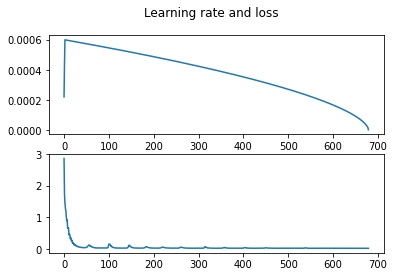

In [6]:
fig, axs = plt.subplots(2)
fig.suptitle('Learning rate and loss')
axs[0].plot(train_results['learning_rate_history'])
axs[1].plot(train_results['loss_history'])

# Testing

We created a few past (for context) + present prompts (player input) and see the different reactions. This way, we can test the models across different iterations.

In [7]:
def generate_dragon_reply(past, prompt, top_k=None, top_p=None):
    model = train_results['model']
    tokenizer = train_results['tokenizer']
    model.eval()
    prompt = f'{past} PlayerReply c "{prompt}" DragonReply'
    generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
    generated = generated.to(device)

    sample_outputs = model.generate(
        generated, 
        do_sample=(top_k is not None and top_p is not None),
        top_p=top_p,
        top_k=top_k,
        pad_token_id=tokenizer.eos_token_id,
        max_length=128,
        num_return_sequences=1
    )
    return tokenizer.decode(sample_outputs[0], skip_special_tokens=False)[len(prompt):].strip()

prompts = [
    ('PlayerReply c "Hey Remy!" DragonReply Ry "Hey!"', "How are you?"),
    ('PlayerReply c "I was with Lorem today." DragonReply Ad "That\'s awesome. He\'s a cute fellow."', "What do you think of Lorem?"),
    ('DragonReply m "In Tatsu park, Adine and I sat down."', "Oh my god, Adine. What is this?"),
    ('DragonReply m "I sat down on a chair in Anna\'s lab."', "What will we do here?"),
]

# Set a fixed seed to make sure we get the same response every time.
torch.manual_seed(80085)
for (past, prompt) in prompts:
    reply = generate_dragon_reply(past, prompt)
    print(f"Prompt: {prompt}\nReply: {reply}\n\n")

Prompt: How are you?
Reply: Ry "Hey."<|endoftext|>


Prompt: What do you think of Lorem?
Reply: Lo happy "It's good to see you! It's a big mystery."<|endoftext|>


Prompt: Oh my god, Adine. What is this?
Reply: Ad "My name is Amely, and she's just the sweetest little girl."<|endoftext|>


Prompt: What will we do here?
Reply: Sb "I'll have to see if I can make it. I'll have to get back to work now."<|endoftext|>




# Sampling test

Which combination is the best?

In [8]:
for i in range(100):
    torch.manual_seed(80085)
    top_k = random.randint(0, 100)
    top_p = round(random.uniform(0, 1), 2)
    for (past, prompt) in prompts:
        reply = generate_dragon_reply(past, prompt, top_k = top_k, top_p = top_p)
        print(f"[Test {i + 1} top_k: {top_k}, top_p: {top_p}] -> Prompt: {prompt}\nReply: {reply}\n")
    print("-------------")

[Test 1 top_k: 86, top_p: 0.77] -> Prompt: How are you?
Reply: Ry "Hey, [player_name]! Good to see you."<|endoftext|>

[Test 1 top_k: 86, top_p: 0.77] -> Prompt: What do you think of Lorem?
Reply: Lo happy "Well, he's a delivery flyer."<|endoftext|>

[Test 1 top_k: 86, top_p: 0.77] -> Prompt: Oh my god, Adine. What is this?
Reply: Ad "My name is Vara, and she -"<|endoftext|>

[Test 1 top_k: 86, top_p: 0.77] -> Prompt: What will we do here?
Reply: Sb "I'll have to see if I can make it. I'll have to get back to work before the afternoon sun hung low in the sky and I decided it was time to report my findings to the police. A brief call to the department, and I was on my way to an appointment with Sebastian."<|endoftext|>

-------------
[Test 2 top_k: 100, top_p: 0.46] -> Prompt: How are you?
Reply: Ry "Hey, [player_name]."<|endoftext|>

[Test 2 top_k: 100, top_p: 0.46] -> Prompt: What do you think of Lorem?
Reply: Lo happy "It's good to see you! It's a big mystery."<|endoftext|>

[Test 2 

In [ ]:
print("What to say?")
print(generate_dragon_reply("", input()))

What to say?
